# Section 4.2 2 and 4.2.3
# Surface loading and barometer effect

## Setting op a general animation environment that can do animations of complex drawings in which lines and patches are mixed while using `matplotlib.animation.FuncAnimation`

How to visualize the surface loading and barometer effects and how to they relate?

(see exercise 14 on page 27 of the syllabus.


T.N. Olsthoorn (2020-12-15)

## Concept:

One can imagine the confined aquifer as a cylinder with a piston on top carrying the overbuden, the load, while inside there is a spring, while the cylinder is filled with water. There is also a piezometer that perforates the piston to allow measuring the pressure inside. Hence the load on top of the piston is carried by both the spring and the water. The portion carried by the water and that carrie by the spring depends on the stiffness of both the spring and the water. When the water is compressed, the water level in the piezometer reflects the change of water pressure under the piston. Notice that the watervolume in the piezometer is completely negligible compared to the volume inside the cylinder. Hence the piston represents the elasticity of the aquifer skeleton, the pore matrix.

In [455]:
pwd

'/Users/Theo/Instituten-Groepen-Overleggen/IHE/git/TransientGroundwaterFlow/excercises_notebooks'

In [420]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import Patch, PathPatch, Rectangle
from matplotlib.transforms import Bbox
from matplotlib.lines import Line2D
from matplotlib.text import Text
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import animation

import pdb

rho = 1e3 # kg/m3
g = 9.81 # N/kg

attribs = lambda obj: [o for o in dir(obj) if not o.startswith('_')]

def counter():
    for ic in range(250):
        yield ic
        
def clrs():
    """Generator, each time yielding next color."""
    colors = ['red', 'blue', 'green','black', 'magenta', 'cyan', 'brown', 'gold', 'orange', 'gray']
    for ic in range(100):
        clr = colors[ic % len(colors)]
        yield clr


def newfig(title="title", xlabel="xlabel", ylabel="ylabel",
           xlim=None, ylim=None, xscale='linear', yscale='linear', size_inches=(12, 8)):
    fig, ax = plt.subplots()
    fig.set_size_inches(size_inches)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.grid()
    return ax

STOP, MOVETO, LINETO, CLOSEPOLY = 0, 1, 2, 79

# General functions and parameterized Path definitions to be used for the defined things. Some are general and some are specific.

In [202]:
deg2rad = lambda a: np.pi * a / 180.

def joinpaths(pth1, pth2):
    """Join two paths."""
    vertices = np.vstack((pth1.vertices, pth2.vertices))
    codes = np.hstack((pth1.codes, pth2.codes))
    return Path(vertices, codes=codes)

def path2xy(path):
    """Return the path as a list of xy lines."""
    I = np.arange(len(path.codes), dtype=int)[path.codes == MOVETO]
    I = np.hstack((I, len(path.codes)))
    lines = []
    for i, j in zip(I[:-1], I[1:]):
        lines.append(path.vertices[i:j])
    return lines


def plotpath(path, ax=None, **kw):
    """Plot a path, passing kw to ax.plot."""
    lines = path2xy(path)
    for line in lines:
        ax.plot(*line.T, **kw)

def path_transform(path, rotdegr=0., aspect=1, dx=0, dy=0):
    """Return tranformed path.
    
    Parameters
    ----------
    path: Path object
        the entry path
    rotdegr: float
        desired rotation in degrees, anti-clockwise
    aspect: float
        dy/dx scale, desired aspect ratio.
    dx, dy: floats
        translation of the path
    """
    sa = np.sqrt(aspect)
    a  = deg2rad(rotdegr)
    T = np.array([
         [  1/sa * np.cos(a), -sa * np.sin(a), dx],
         [  1/sa * np.sin(a),  sa * np.cos(a), dy],
         [  0,                  0,              1]])
    xy1 = np.vstack((path.vertices.T, np.ones((1, len(path.vertices)))))
    XY = T @ xy1
    return Path(XY[:2].T, path.codes)


def set_needle(needle_path, pressure=0.25, a0=165, a1=15, p0=0, p1=1, aspect=1):
    """Turn the gauge needle to the desired angle."""
    angle = a0 + (pressure - p0) / (p1 - p0) * (a1 - a0)
    return path_transform(needle_path, rotdegr=angle, aspect=aspect)


def test_path_transform():
    """Plot rectangle and a circle to show the path transform at work."""
    
    # Rectangle
    rect = Path(np.array([[0, 0,], [0, 1], [1, 1], [1, 0], [0, 0]]), codes=[1, 2, 2, 2, 2])
    newrect = path_transform(rect, rotdegr=45, aspect=0.5, dx=0.5, dy=0.5)

    # Circle
    a = deg2rad(np.linspace(0, 360, 37))
    r = 0.5
    circ = np.vstack((r * np.cos(a), r * np.sin(a))).T
    codes = np.ones(len(circ)); codes[1:] = LINETO; codes[-1] = CLOSEPOLY
    circle = Path(circ, codes)
    newcircle = path_transform(circle, rotdegr=0, aspect=0.5, dx=0.5, dy=0.5)

    # Plot it
    ax = newfig("Plot a path and its transform","x","y")
    plotpath(rect, ax=ax, color='magenta')
    plotpath(newrect, ax=ax, color='k')

    plotpath(circle, ax=ax, color='magenta')
    plotpath(newcircle, ax=ax, color='k')
    ax.set_aspect(1.)

        
#%% Paths for different objects
    
def p_arc(x0=None, y0=None, r=None, a=(15, 165), aspect=1., close=False):
    """Return n points on a the circle with radius r between angles a0 and a1 (degrees)."""
    n = max(1, abs((a[1] - a[0])) / 15)
    alpha = deg2rad(np.linspace(a[0], a[1], n + 1))
    ry = r * np.sqrt(aspect)
    rx = r / np.sqrt(aspect)
    xy  = np.vstack((x0 + rx * np.cos(alpha),
                     y0 + ry * np.sin(alpha))).T
    codes = np.ones(len(xy)); codes[1:] = LINETO
    if close:
        xy = np.vstack((xy, xy[:1]))                        
        codes = np.hstack((codes, CLOSEPOLY))
    return Path(xy, codes=codes)


def p_spring(x0=None, y0=None, w=None, h=None, n=300, n1=25):
    """Generate a spring path."""
    r = w / 2
    theta = np.linspace(-0.5, 10.5, n) * 2 * np.pi
    xy = np.vstack(( x0 + r * np.cos(theta),
                     y0 + np.hstack((np.linspace(0.00, 0.01, n1),
                        np.linspace(0.01, 0.99, n-n1-n1),
                        np.linspace(0.99, 1.00, n1))) * h)).T
    codes = np.ones(len(xy));     codes[1:] = LINETO
    return Path(xy, codes=codes)


def p_rect(x0=None, y0=None, w=None, h=None):
    """Genearate a rectangle path."""
    b = w / 2
    xy = np.array([[- b, 0],
                   [+ b, 0],
                   [+ b, 0 + h],
                   [- b, 0 + h],
                   [- b, 0     ]]) + np.array([[x0, y0]])
    codes = [MOVETO, LINETO, LINETO, LINETO, CLOSEPOLY]
    return Path(xy, codes=codes)


def p_tube(x0=None, y0=None, w=None, h=None):
    "Generate a path like a tube (2 walls in cross section)."
    b = w / 2
    xy = np.array([[- b, 0    ],
                   [- b, 0 + h],
                   [+ b, 0    ],
                   [+ b, 0 + h]]) + np.array([[x0, y0]])
    codes = [MOVETO, LINETO, MOVETO, LINETO]
    return Path(xy, codes=codes)


def p_arrow(x0=None, y0=None, h=None, w=None, m=4):
    """Return the arrow as a path.Path.

    Parameters
    ----------
    m: float
        height of arrow point = m * self.w /2
    """
    b = w / 2
    xy = np.vstack((x0 + np.array([0, 0, -b, 0, b, 0, 0]),
                    y0 + np.array([h, 0,  m * b, 0.75 * m * b, m * b, 0, h]))).T
    codes = np.ones(len(xy), dtype=int) * LINETO;  codes[0] = MOVETO
    return Path(xy, codes=codes)


def p_arrows(x0=None, y0=None, w=None, h=None, n=10, skip=None):
    """Return path of multiple arrows next to eachother as lines

    Parameters
    ----------
    x0, y0, w, h
    x0: float
        left most point of line to be filled with arrows.
    y: float
        elevation of downward pointing arrow point
    h: float
        height of the arrows
    w: float
        widtch over which the n arrows should be plotted.
    n:  int
        number of arrows to plot over width w starting at x=x    
    skip: int or iterable of ints
        numbers of arrows to skip (not to draw)
    """
    x1 = x0 + w
    b = w / n / 2
    path = None
    if np.isscalar(skip):
        skip = [skip]
    for i, x in enumerate(np.arange(x0 + b, x1, 2 * b)):
        if path is None:
            path = p_arrow(x0=x, y0=y0, w=0.9 * w / n, h=h)
        elif not i in skip:        
            path = joinpaths(path, p_arrow(x0=x, y0=y0, w = 0.9 * w / n, h=h))
    return path


def p_gauge(x0=0, y0=0, w=0.4, ntick=10, pressure=0.25, aspect=1.0, show=False):
    """Return compound paths of a gauge with housing, needle and ticks.

    Parameters
    ----------
    x0, y0, floats,
        center of needle = center of gauge
    w: float
        diamter of the gauge housing
    ntick: int
        number of needle ticks on the gauge
    aspect: float
        desired dy/dx ratio, scaling.
    pressure: float
        relative pressure to set the gauge-needle
    show: bool
        plots the gauge if True.
    """
    def set_needle(needle_path, pressure=0.25, a0=165, a1=15, p0=0, p1=1, aspect=1):
        """Turn the gauge needle to the desired angle."""
        angle = a0 + (pressure - p0) / (p1 - p0) * (a1 - a0)
        return path_transform(needle_path, rotdegr=angle, aspect=aspect)

    #Housing x0, y0, rh, ah, dh
    rh = w /2 # Radius of the gauge's housing.
    p_housing = p_arc(x0=x0, y0=y0, a=(-15, 195), r=rh, aspect=aspect)

    # Needle of the gauge (not yet rotated)
    L_needle = 0.90 * rh # length of the needle
    r_needle = 0.02 * rh # radius of needle root
    a_needle_head = (90, 270) # angle range of the needle in degrees
    xypoint=np.array([[x0 + L_needle, y0]]) # Top of needle when created
    xy = p_arc(x0=x0, y0=y0, a=a_needle_head, r=r_needle, aspect=aspect).vertices
    xy = np.vstack((xypoint, xy, xypoint))
    codes = np.ones(len(xy)); codes[1:] = LINETO; codes[-1] = CLOSEPOLY
    p_needle = Path(xy, codes)

    # Ticks x0, y0, r0t, r1t, at0, at1, nt 
    rt0 = 0.85 * rh # outer radius of tick stripe
    rt1 = 0.95 * rh # inner radius of tick stripe
    a_ticks = (165, 15) # Angles voor the tickes to vary between
    xy0 = p_arc(x0=x0, y0=y0, a=a_ticks, r=rt0, aspect=aspect).vertices
    xy1 = p_arc(x0=x0, y0=y0, a=a_ticks, r=rt1, aspect=aspect).vertices
    xy = []
    for p1, p2 in zip(xy0, xy1):
        xy.append(list(p1))
        xy.append(list(p2))
    xy = np.array(xy)
    codes = np.array([[MOVETO, LINETO] for p in xy0]).flatten()
    p_ticks = Path(xy, codes)

    # Turn needle to zero-pressure
    p_needle = set_needle(p_needle, pressure, a0=a_ticks[0], a1=a_ticks[1])

    # Show what the gauge looks like:
    if show:
        ax = newfig("Gauge", "x", "y")
        for p, clr in zip([p_housing, p_needle, p_ticks], clrs()):
            plotpath(p, ax=ax, color=clr)
        plt.show()

    return p_housing, p_needle, p_ticks


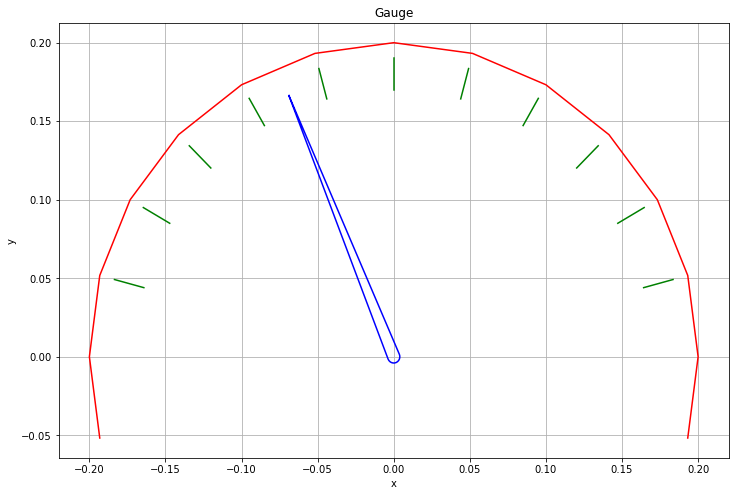

In [203]:
#test_path_transform()
_ = p_gauge(x0=0, y0=0, w=0.4, ntick=10, aspect=1.0, show=True, pressure=0.35)

# Definition of the general Thing class and a series of subclasses of specific Things used in the animation.

In [374]:
# Permissible keys for patches, lines and texts
patch_keys = ['ls', 'lw', 'ec', 'fc', 'linestye', 'linewidth', 'egecolor', 'facecolor', 'alpha',
             'fill', 'zorder', 'label']
line_keys = ['label', 'ls', 'linestyle', 'lw', 'linewidth', 'c', 'color', 'marker', 'mec', 'markeredgecolor',
             'mfc', 'markerfacecolor', 'mew', 'markeredgewidth', 'ms', 'markersize', 'markevery', 'zorder']
text_keys = ['position', 'rotation', 'label', 'linespacing', 'c', 'color', 'backgroundcolor', 'ha', 'horizontalalignment', 'va', 'verticalalignment', 'ma', 'multialignment',
             'usetex', 'alpha',
             'font', 'fontproperties', 'family', 'fontfamily', 'size', 'fontsize', 'weight', 'fontweight',
             'variant', 'fontvariant', 'style', 'fontstyle', 'stretch', 'fontstretch']

# Select functions for permissible keys
p_kw = lambda kw: {k:kw[k] for k in kw if k in patch_keys}
l_kw = lambda kw: {k:kw[k] for k in kw if k in line_keys}
t_kw = lambda kw: {k:kw[k] for k in kw if k in text_keys}


class Thing:
    """Class of things. Each thing can be placed on an axis at a precice location using its
    x0, y0 anchor points, and can be widend and stretched using its parameters `w` and `h`.
    
    This means each Thing can be treated indiependly of other Things.
    
    And it's position and size are updated ne resetting their x0, y0, w and h parameters.

    Different thing types are defined in separate classes with recognizable names that are combined
    in a single drawing and can be maniputlated by changing their parameter values.
    
    A thing may of tow ypes: Line2D and Patch, where a Line2 is a line or multiline defined by a
    matplotlib.Path path and Patch is a patch object defined by a matplotlib.patches.Patch.
    With the Path codes, any combination of lines can be drawn by setting the code for each path vertex
    (MOVETO, LINETO, CLOSEPOLY).
    
    During the animation, only the path of the objects is updated, allowing each object ot move stretch
    and shrin as needed. 

    Things may be combined in a Things_collection so they can be treated as a single compound object.

    The parent class, "Thing" holds all parameters and functions common to all Thing types.
    
    The Thingpath is updated upon a plotting instruction. When plotting the path is updated, the artists
    that the Thing holds from the past are deleted and new artists are generated and placed on the
    appropriate axes. When updating as in the animation loop, the path of each object may be adapted and
    replaced, to that the object can be moved and stretched, shrinked without generating new ones. Each Thing
    carries its own artists in a list.

    @TO 2020-12-20
    """
    
    def __init__(self, name='name', artist_type=Line2D, x0=0, y0=0, w=1.0, h=1.0, aspect=1.0, **kw):
        """Instantiate a Thing. Note that the Thing class should not be called directly, only as
           the superclass of specified Things defined as separate classes below.
        """
        self.name = name # Any name for the instantiated Thing
        self.artist_type = artist_type # Either Line2D or Patch
        self.x0 = x0  # Anchor point
        self.y0 = y0  # Anchor point
        self.w = w    # width of object
        self.h = h    # height of object
        self.asp = aspect # aspect ratio, dy/dx
        self.kw = kw # Other parameters passed on to Line2D, Patch or Text
        self.bbox = Bbox.null() # Initial bounding box
        self.artists = [] # List of artsts pertaining to Thing

    def bbox_update(self):
        self.bbox.update_from_path(self.path)
        
    def _update(self, x0=None, y0=None, h=None, w=None):
        """Update the Thing parameters that defined the path.
        
        Updating of the self parameters is required before plotting
        and updating because the self parameters are used by
        each Thing to compute or update its Path.
        
        Updating is done before adding an artist to patches, lines or texts.
        See add_patches, add_lines and add_texts.
        """
        self.x0 = self.x0 if not x0 else x0
        self.y0 = self.y0 if not y0 else y0
        self.h  = self.h  if not h  else h
        self.w  = self.w  if not w  else w
            
    def add_patches(self, x0=None, y0=None, h=None, w=None, ax=None, **kw):
        """For artist_type == Patch, add artists to axes"""
        self._update(x0=x0, y0=y0, h=h, w=w)
        self.artists.append(PathPatch(self.path, **p_kw(self.kw)))
        for artist in self.artists:
            ax.add_patch(artist)
        self.bbox_update()
        
    def update_patches(self, x0=None, y0=None, h=None, w=None):
        """Update the path of the artists of the Thing in question."""
        self._update(x0=x0, y0=y0, h=h, w=w)
        for artist in self.artists:
            artist.set_path(self.path)

    def add_lines(self, x0=None, y0=None, h=None, w=None, ax=None, **kw):
        """For artist_type==Line2D, add the line-artists to the axes."""
        path = self.path
        self.bbox_update()
        I = np.arange(len(path.codes), dtype=int)[path.codes == MOVETO]
        I = np.hstack((I, len(path.codes)))
        for i, j in zip(I[:-1], I[1:]):
            xy = path.vertices[i:j]
            line = Line2D(*xy.T, label=self.name, **kw)
            self.artists.append(line)
            ax.add_line(line)

    def update_lines(self, x0=None, y0=None, h=None, w=None):
        """Update the path of the artists of the Thing in question."""
        self._update(x0=x0, y0=y0, h=h, w=w)
        xys = path2xy(self.path)
        for ln, xy in zip(self.artists, xys):            
            ln.set_data(*xy.T)

    def add_text(self, x0=None, y0=None, text='text?', ax=None, **kw):
        """Add a text to a Thing."""
        self._update(x0=x0, y0=y0, h=h, w=w)
        self.artists.append(Text(x0, y0, text, **kw))
        for artist in self.artists:
            ax.add_text(artist)
        
    def update_text(self, x0=None, y0=None, text='text?'):
        self._update(x0=x0, y0=y0, w=None, h=None)
        for artist in self.artists:
            text.set_text(text)
            
    def plot(self, x0=None, y0=None, h=None, w=None, ax=None, **kw):
        """Plot the Thing's artists after first regenerating them.
        
        This is used to first place the artists of the Thing on the axes.        
        """
        self.artists = []
        if self.artist_type == Line2D:
            self.add_lines(x0=x0, y0=y0, h=h, w=w, ax=ax, **l_kw(kw))
        elif self.artist_type == Patch:
            self.add_patches(x0=x0, y0=y0, h=h, w=w, ax=ax, **p_kw(kw))
        elif self.artist_type == Text:
            text = ignore['text']
            self.add_texts(x0=x0, y0=y0, h=h, w=w, ax=ax, text=text, **t_kw(kw))
        else:
            raise TypeError(f"Unrecogized artist type {self.artist_type}.")

    def update(self, x0=None, y0=None, h=None, w=None, **ignore):
        """Update the path of the artists already on the axes."""
        if self.artist_type == Line2D:
            self.update_lines(x0=x0, y0=y0, h=h, w=w)
        elif self.artist_type == Patch:
            self.update_patches(x0=x0, y0=y0, h=h, w=w)
        elif self.artist_type == Text:
            self.update_texts(x0=x0, y0=y0, h=h, w=w, text=ignore['text'])
        else:
            raise TypeError(f"Unrecogized artist type {self.artist_type}.")

# Specific classes. Each of them uses the methods of the super class Thing to the
# extent possible. Each of the subclasses has a property `path(self)` that generates
# its path using the self parameters self.x0, self.y0, self.w and self.h. Sometimes
# other parameters can be used but preferably not.
# During the simulation the paths are updated, simply by updating the self parameters
# x0, y0, w and h. Each path(self) calls its specific path defined above.

class Tube(Thing):
    "A tube is a cylinder drawn as two parallel vertical lines."
    def __init__(self, name, x0=0, y0=0, w=None, h=None, **kw):
        super().__init__(name, artist_type=Line2D, x0=x0, y0=y0, w=w, h=h, **kw)

    @property
    def path(self):
        return p_tube(x0=self.x0, y0=self.y0, w=self.w, h=self.h)

        
class Arrow(Thing):
    "An arrow is an arrow drawn as a Line2D object."
    def __init__(self, name=None, x0=0, y0=0, w=None, h=None, **kw):
        super().__init__(name=name, artist_type=Line2D, x0=x0, y0=y0, w=w, h=h, **kw)
        
    @property
    def path(self):
        return p_arrow(x0=self.x0, y0=self.y0, w=self.w, h=self.h)

class Arrows(Thing):
    """Arrows is a set of n arrows drawn parallel to each other across the given width."""
    def __init__(self, name=None, x0=0, y0=0, w=None, h=None, **kw):
        super().__init__(name=name, artist_type=Line2D, x0=x0, y0=y0, w=w, h=h, **kw)

    @property
    def path(self):
        return p_arrows(x0=self.x0, y0=self.y0, w=self.w, h=self.h,
                        n=self.kw['n'], skip=self.kw['skip'])
        
class Rect(Thing):
    """A rectangle drawn as  a patch."""
    def __init__(self, name=None, x0=0, y0=0, w=None, h=None, **kw):
        super().__init__(name=name, artist_type=Patch, x0=x0, y0=y0, w=w, h=h, **kw)
        
    @property
    def path(self):
        return p_rect(x0=self.x0, y0=self.y0, w=self.w, h=self.h)

class Spring(Thing):
    """A spring drawn vertically."""
    def __init__(self, name=None, x0=0, y0=0, w=None, h=None, **kw):
        super().__init__(name=name, artist_type=Line2D, x0=x0, y0=y0, w=w, h=h, **kw)
       
    @property
    def path(self):
        r1 = self.w / 2
        r2 = r1 / 5
        spr_path = p_spring(x0=self.x0, y0=self.y0, w=self.w, h=self.h, n=300, n1=25)        
        xy = spr_path.vertices
        xy[:, 0] += self.x0
        xy[:, 1] += self.y0
        return Path(xy, codes=spr_path.codes)

    
# A gauge may be composed of three Things: GaugeHousing, Needle and Ticks defined below.
# The actual Gause will be a Thing_collection in which the three parts take their place.

class GaugeHousing(Thing):
    """Gauge housing class."""                            
    def __init__(self, name=None, x0=None, y0=0, w=None, h=None, **kw):
        super().__init__(name=name, artist_type=Patch, x0=x0, y0=y0, w=w, h=h, **kw)
    
    @property
    def path(self):
        """Return the path of the Gauge housing."""
        asp   = 1.    if not 'aspect' in self.kw else self.kw['aspect']
        close = False if not 'close'  in self.kw else self.kw['close']
        return p_arc(x0=self.x0, y0=self.y0, a=self.kw['ah'],
                             r=self.w / 2, aspect=asp, close=close)

class Needle(Thing):
    """Gauge needle class (net yet rotated)."""
    def __init__(self, name=None, x0=None, y0=0, w=None, h=None, **kw):
        """Return the Gauge needle, note that h=pressure."""
        super().__init__(name=name, artist_type=Line2D, x0=x0, y0=y0, w=w, h=h, **kw)
    
    @property
    def path(self):
        """Return path of the Gauge needle."""
        L_needle = 0.90 * self.w / 2 # length of the needle
        r_needle = 0.02 * self.w / 2 # radius of needle root
        a_needle_head = (90, 270) # angle range of the needle in degrees
        xypoint=np.array([[L_needle, 0]]) # Top of needle when created
        asp = 1. if not 'aspect' in self.kw else self.kw['aspect']
        # First put the needle at 0, 0:
        xy = p_arc(x0=0, y0=0, a=a_needle_head, r=r_needle, aspect=asp).vertices
        xy = np.vstack((xypoint, xy, xypoint))
        codes = np.ones(len(xy)); codes[1:] = LINETO; codes[-1] = CLOSEPOLY
        # Generate a flat needle at 0, 0
        needle_path = Path(xy, codes) 
        # Rotate the needle according to the pressure
        needle_path = set_needle(needle_path, pressure=self.h, aspect=asp)
        # Move center of needle to x0, y0 of gauge
        needle_path.vertices += np.array([self.x0, self.y0])
        return needle_path

class Ticks(Thing):
    """Tick value indicaters for the gauge."""
    def __init__(self, name=None, x0=None, y0=0, w=None, h=None, **kw):
        super().__init__(name=name, artist_type=Line2D, x0=x0, y0=y0, w=w, h=h, **kw)
                            
    @property
    def path(self):
        """Return the path of all Gauge ticks."""
        rt0 = 0.85 * self.w / 2 # outer radius of tick stripe
        rt1 = 0.95 * self.w / 2 # inner radius of tick stripe
        a_ticks = (165, 15) # Angles voor the tickes to vary between
        asp = 1. if not 'aspect' in self.kw else self.kw['aspect']
        xy0 = p_arc(x0=self.x0, y0=self.y0, a=a_ticks, r=rt0, aspect=asp).vertices
        xy1 = p_arc(x0=self.x0, y0=self.y0, a=a_ticks, r=rt1, aspect=asp).vertices
        xy = []
        for p1, p2 in zip(xy0, xy1):
            xy.append(list(p1))
            xy.append(list(p2))
        xy = np.array(xy)
        codes = np.array([[MOVETO, LINETO] for p in xy0]).flatten()
        return Path(xy, codes)

# Any drawing can be composed of one or more Thing_collection, each of which may contain
# an arbitrary number of Thing objects. By updating entire Thing_collections, the animation
# remains manageble.

class Thing_collection:
    """A collection of Things. All types of Thing can be entered.
    
    You may have as many thing collections as you want, each containging
    One or  more Things. So the Gauge may be defined as a separate Thing+collection
    """
    
    def __init__(self, thinglist):
        """Return a Thing collection.
        The thinglist contains objects each of which is a Thing as defined above. A thing
        Must then be one of the above defined subclasses of Thing.
        Each thing carries a name that is independent of the class, so that multiple
        Thing objects of the same class can be uniquely adressed by their name.
        Each Thing has an artist_type which is either a Line2D, a Patch or a Text.
        We assume that each artist can have multiple Line2D or Patch or Text objects,
        so the artists are carried in a list, called self.artists which are all of
        the same type as given by artist_type.
        A Thing_collection bundles multiple artists of various type.
        """
        self.things = thinglist
        
    @property
    def artists(self):
        """Return the individual artists (must plot first to set them)."""
        artists = []
        for thing in self.things:
            artists += thing.artists
        return artists

    def plot(self, ax=None, params=None):
        """Plot the artists.
        
        Exmple of params
        ----------------
        params = {'tube': {},
                  'piston': {'y0': zpist},
                  'piezom': {'y0': zpist},
                  'water1': {'h': zpist},
                  'water2': {'y0': zpist},
                  'arrowLoad': {'y0': zpist + hpist},
                  'arrowBarom':, {'y0': zpist + hwpiez}
                   }
        """
        for thing in self.things:
            thing.plot(ax=ax, **params[thing.name])
            
    def update(self, params=None):
        """Update the artists path without plotting them.
        
        Exmple of params
        ----------------
        params = {'tube': {},
                  'piston': {'y0': zpist},
                  'piezom': {'y0': zpist},
                  'water1': {'h': zpist},
                  'water2': {'y0': zpist},
                  'arrowLoad': {'y0': zpist + hpist},
                  'arrowBarom':, {'y0': zpist + hwpiez}
                   }
        """
        for thing in self.things:
                thing.update(**params[thing.name])
        

In [440]:
# Paramters to define the object posistions and their size.

Baro = True

h_cylinder, h_piston, h_piezom, hw_piezom   = 1.10, 0.20, 0.50, 0.30
w_cylinder, w_piezom, w_spring = 1.00, 0.02, 0.20

x_piezom = 0.40
z_piston = 0.80
w_arrow, h_arrow = 0.03, 0.3


setup_pars = {
          'tube':   {'x0':0, 'y0':0, 'w':w_cylinder,'h':h_cylinder,
                                                         'color':'black', 'lw':3},
         'piston':  {'x0':0, 'y0':z_piston,'w':w_cylinder, 'h':h_piston,
                                                 'ec':'black', 'fc':'brown', 'lw':2},
         'piezom':  {'x0':x_piezom,'y0':z_piston,'w':w_piezom,'h':h_piezom,
                                                             'color':'black', 'lw':2},
         'water1':  {'x0':0, 'y0':0, 'w':w_cylinder, 'h':z_piston,
                                                'ec':'none', 'fc':'cyan','alpha':0.5},
         'water2':  {'x0':x_piezom,'y0':z_piston,'w':w_piezom,'h':hw_piezom,
                                                'ec':'none', 'fc':'cyan','alpha':0.5},
         'spring':  {'x0':0, 'y0':0, 'w':w_spring, 'h':z_piston,
                                                             'color':'black', 'lw':3},
         'arrowLd': {'x0':-0.5 * w_cylinder, 'y0':z_piston + h_piston, 
                     'w':w_cylinder, 'h':h_arrow,
                     'n':15, 'skip':13, 'color':'black', 'lw':1},
         'arrowBr': {'x0':x_piezom , 'y0': z_piston + hw_piezom,
                     'w':w_cylinder / 15, 'h':h_arrow, 'color':'black', 'lw':1}
          }

# Define the Thing_collection called "setup" for this simulations
# First define the individual Things with initial parameters
tube    = Tube(  'tube',    **setup_pars[  'tube'])
piezom  = Tube(  'piezom',  **setup_pars['piezom'])
piston  = Rect(  'piston',  **setup_pars['piston'])
water1  = Rect(  'water1',  **setup_pars['water1'])
water2  = Rect(  'water2',  **setup_pars['water2'])
spring  = Spring('spring',  **setup_pars['spring'])
arrowLd = Arrows('arrowLd', **setup_pars['arrowLd'])
arrowBr = Arrow('arrowBr',  **setup_pars['arrowBr'])

# Then put the Things in a list
thingslist = [tube, piezom, piston, water1, water2, spring, arrowLd]
if Baro:
    thingslist.append(arrowBr)

# And combine them in a Thing_collection
setup = Thing_collection(thingslist)

# Define the gauge
# Here are its parameters (for the housing, the ticks and the needle)
x0, y0, w_housing, pressure = 0.3, 0.2, 0.25, 0.5
gauge_pars = {'housing': {'x0':x0, 'y0':y0, 'w':w_housing, 'ah':(-15, 195), 'aspect':1.,
                                                         'fc':'white', 'ec':'black'},         
              'ticks':   {'x0':x0, 'y0':y0, 'w':w_housing, 'color':'black', 'lw':3},
              'needle':  {'x0':x0, 'y0':y0, 'w':w_housing, 'h':pressure, 'color':'red', 'lw':1}
             }

# Define the Thing_collection called "gauge"
gauge = Thing_collection([GaugeHousing('housing', **gauge_pars['housing']),
                          Ticks('ticks',          **gauge_pars['ticks']),
                          Needle('needle',        **gauge_pars['needle'])
                         ])

# Update the setup_pars (when necessary)
# setup_pars['piston'].update(y0=z_piston)
# setup_pars['piezom'].update(y0=z_piston)
# setup_pars['water1'].update(h=z_piston)
# setup_pars['water2'].update(y0=z_piston, h=hw_piezom)
# setup_pars['spring'].update(h=z_piston)
# setup_pars['arrowLd'].update(y0=z_piston + h_piston, h=h_arrow)
# setup_pars['arrowBr'].update(y0=z_piston + hw_piezom, h=h_arrow)

# # Update the gauge_pars
# gauge_pars['needle'].update(h=pressure)


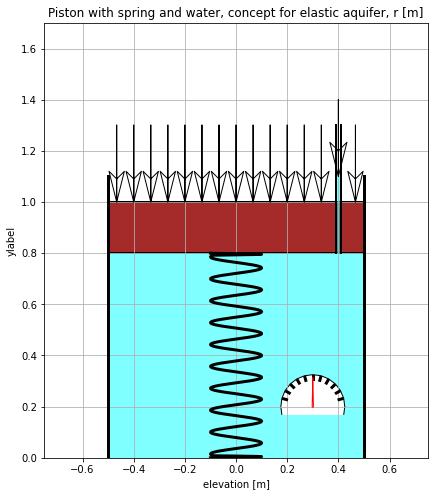

In [441]:
# TEST to see if it works

ax = newfig('Piston with spring and water, concept for elastic aquifer, ''r [m]',
           'elevation [m]')
ax.set_xlim(-0.75, 0.75)
ax.set_ylim(0, 1.7)

x0 = 0
y0 = 0.

setup.plot(ax=ax, params=setup_pars)
gauge.plot(ax=ax, params=gauge_pars)
ax.set_aspect(1.)

# Animate the two Thing_collections `setup` and `gauge`.

In [447]:
# Simulation data

ax = newfig('Piston with spring and water, concept for elastic aquifer')
fig = ax.figure
ax.set_xlim(-0.75, 0.75)
ax.set_ylim(0, 1.7)
ax.set_aspect(1.)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
x0 = 0
y0 = 0.

# Amplitudes to use
dpressure, dzpiston, dhwpiez, dharrow = 0.35, 0.05, 0.15, 0.1

# 1 complete up and down cycle in 100 steps
theta = np.linspace(0, 4 * np.pi, 200)

# Define the time series for the parameters that vary during the animation
Pressure = 0.5 + dpressure * np.sin(theta)
Zpiston  = z_piston - dzpiston  * np.sin(theta)
if Baro:
    Hwpiez   = hw_piezom  - dhwpiez   * np.sin(theta)
else:
    Hwpiez   = hw_piezom  + dhwpiez   * np.sin(theta)
    
Harrow   = h_arrow  + dharrow * np.sin(theta)

# Update the setup_pars, to make everything comply with the actual data
setup_pars['piston'].update(y0=z_piston)
setup_pars['piezom'].update(y0=z_piston)
setup_pars['water1'].update(h=z_piston)
setup_pars['water2'].update(y0=z_piston, h=hw_piezom)
setup_pars['spring'].update(h=z_piston)
setup_pars['arrowLd'].update(y0=z_piston + h_piston, h=h_arrow)
setup_pars['arrowBr'].update(y0=z_piston + hw_piezom, h=h_arrow)
# Update the gauge_pars
gauge_pars['needle'].update(h=pressure)

# Plot the artists,
# This removes existing artists generates new ones
setup.plot(ax=ax, params=setup_pars)
gauge.plot(ax=ax, params=gauge_pars)
if Baro:
    ax.text(0.2, 0.9, "Varying barometer pressure.", size=12, transform=ax.transAxes)
else:
    ax.text(0.2, 0.9, "Varying surface loading.", size=12, transform=ax.transAxes)
    
# Define the animation functions
def init(): # Initialize the background (blanc)
    for artist in setup.artists: # + gauge.artists:
        if isinstance(artist, Line2D):
            artist.set_data([], []) # empty the Line2D objects
        elif isinstance (artist, Patch):
            artist.get_path().vertices=[] # Empty the vertices of the path of patches
        elif isinstance(artist, Text):
            artist.set_text('')  # Empty the text of texts
        else:
            raise TypeError(f"Unknown type: {type(artist)}")
    # Return all the artists (updated or not)
    return setup.artists + gauge.artists


def animate(timedata): 
    """Animate. timedata is a sequence, zie the zip in the call."""
    pressure, z_piston, hw_piezom, h_arrow =  timedata

    # Update the setup_pars
    # We only need to update the ones that have their path updated
    setup_pars['piston'].update(y0=z_piston)
    setup_pars['piezom'].update(y0=z_piston)
    setup_pars['water1'].update(h=z_piston)
    setup_pars['water2'].update(y0=z_piston, h=hw_piezom)
    setup_pars['spring'].update(h=z_piston)
    setup_pars['arrowLd'].update(y0=z_piston + h_piston, h=h_arrow)
    setup_pars['arrowBr'].update(y0=z_piston + hw_piezom, h=h_arrow)
    # Update the gauge_pars, only the needle (pressure)
    gauge_pars['needle'].update(h=pressure)

    # Update the two Thing_collections
    setup.update(setup_pars)
    gauge.update(gauge_pars)

    # Return all the artists (updated or not)
    return setup.artists + gauge.artists

# Do the animation
anim = FuncAnimation(fig, animate, init_func=init,
                                   frames=zip(Pressure, Zpiston, Hwpiez, Harrow),
                                   fargs=None,
                                   interval=100, blit=True, repeat=True)
print('Done!')

plt.close(anim._fig)
#out = HTML(anim.to_html5_video())
#out # to actually show the video.

Done!


In [453]:
len(Harrow)

200

In [454]:
if Baro:
    fname= 'Barometer_animation'
else:
    fname= 'Loading_animation'
    

Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1000)

if False:
    #writer = PillowWriter(fps=25)  
    #ani.save("BaroDemo.gif", writer=writer) 
    fname="BaroTest"
    anim.save(fname + '.gif', writer=writer)
else:
    anim.save(fname + '.mp4', fps=15, extra_args=['-vcodec', 'libx264'])

print(anim.save_count, " frames saved.") # Shows the number of frames saved.

100  frames saved.
